In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
sns.set()

%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
def generate_data():
    n = 30
    x = np.random.random((n,1))
    f_x_sampled = 4*np.sin(np.pi*x)*np.cos(6*np.pi*(x**2))
    
    eps = np.random.randn(n,1)
    y = f_x_sampled + eps
    
    x_cont = np.arange(0,1,0.001)
    f_x = 4*np.sin(np.pi*x_cont)*np.cos(6*np.pi*(x_cont**2))

    return x,y,f_x,x_cont

def make_K_mat_rbf(x,gamma):
    K = np.zeros((x.shape[0],x.shape[0]))
    
    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            K[i][j] = np.exp(-gamma*(np.linalg.norm(x[i]-x[j])**2))
            
    return K


def make_K_mat_poly(x,d):
    K = np.zeros((x.shape[0],x.shape[0]))

    for i in np.arange(x.shape[0]):
        for j in np.arange(x.shape[0]):
            terms_to_eval = (1+np.dot(x[i].T,x[j]))
            K[i][j] = terms_to_eval**d
    return K

def kernel_eval_rbf(gamma,x_1,x_2):
    eval_kernel = []
    
    for i in np.arange(x_2.shape[0]):
        eval_iter = float(np.exp(-gamma*(np.linalg.norm(x_1-x_2[i])**2)))
        eval_kernel.append(eval_iter)
    return eval_kernel 

def bootstrap_poly(d,lambda_val,x,y,data,num_sets,num_pulls):
    bootstrapped_examples = np.zeros((num_sets,data.shape[0]))
    inds = np.arange(num_pulls)
    for j in np.arange(num_sets):
        inds_choice = np.random.choice(inds,num_pulls)
        x_samp = x[inds_choice]
        y_samp = y[inds_choice]

        f_hat = np.zeros((data.shape))

        K = make_K_mat_poly(x_samp,d)
        alpha_hat = alpha_hat_compute(K,lambda_val,y_samp)

        for i in np.arange(data.shape[0]):
            eval_kernel = kernel_eval_poly(d,float(data[i]),x_samp)
            predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))

            f_hat[i] = predict_y
        
        bootstrapped_examples[j,:] = f_hat
    
    return bootstrapped_examples

def bootstrap_rbf(gamma,lambda_val,x,y,data,num_sets,num_pulls):
    bootstrapped_examples = np.zeros((num_sets,data.shape[0]))
    inds = np.arange(num_pulls)
    for j in np.arange(num_sets):
        inds_choice = np.random.choice(inds,num_pulls)
        x_samp = x[inds_choice]
        y_samp = y[inds_choice]

        f_hat = np.zeros((data.shape))

        K = make_K_mat_rbf(x_samp,gamma)
        alpha_hat = alpha_hat_compute(K,lambda_val,y_samp)

        for i in np.arange(data.shape[0]):
            eval_kernel = kernel_eval_rbf(gamma,float(data[i]),x_samp)
            predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))

            f_hat[i] = predict_y
        
        bootstrapped_examples[j,:] = f_hat
    
    return bootstrapped_examples

def kernel_eval_poly(d,x_1,x_2):
    
    eval_kernel = []
         
    for i in np.arange(x_2.shape[0]):
        eval_iter = float((1+np.dot(x_1,x_2[i]))**d)
        eval_kernel.append(eval_iter)
    
    return eval_kernel

def alpha_hat_compute(K,lambda_val,y):
    
    lhs = K + lambda_val*np.identity(np.shape(K)[0])
    alpha_hat = np.linalg.solve(lhs,y)
    
    return alpha_hat

def choose_gamma(x):
    dist_vals = []
    for i in np.arange(x.shape[0]):
        for j in np.arange(i):
            dist_vals.append((np.linalg.norm(x[i] - x[j])**2))
            
    median_val = np.median(np.array(dist_vals))
    gamma = 1/median_val
    return gamma

def f_hat_compute(K,alpha_hat):
    f_hat = np.dot(alpha_hat,K)
    
    return f_hat

def LOOCV_rbf(x,y,lambda_vec,gamma_vec):
    
    cost_vec = np.zeros((lambda_vec.shape[0],gamma_vec.shape[0]))
    lambda_iter = 0
    
    for lambda_val in lambda_vec:
        
            gamma_iter = 0
            
            for gamma_ind in gamma_vec:
                print('lambda = {},gamma = {}'.format(lambda_val,gamma_ind))


                score_ind = []
            
                for valid_ind in np.arange(y.shape[0]):
                    mask = np.ones(np.shape(y))
                    mask[valid_ind] = 0
                    mask = mask.astype('bool')
                    y_train = y[mask]
                    y_test = y[valid_ind]
                    x_train = x[mask]
                    x_test = x[valid_ind]

                    K = make_K_mat_rbf(x_train,gamma_ind)
                    alpha_hat = alpha_hat_compute(K,lambda_val,y_train)

                    eval_kernel = kernel_eval_rbf(gamma_ind,x_test,x_train)
                    predict_y = np.array([np.sum(alpha_hat.flatten()*eval_kernel)])
                    cost_ind = cost_func(predict_y,y_test)
                    score_ind.append(cost_ind)


                score = (1/len(score_ind))*np.sum(score_ind)
                cost_vec[lambda_iter][gamma_iter] = score
                
                gamma_iter += 1 
        
            lambda_iter += 1
    
    return cost_vec

def LOOCV_poly(x,y,lambda_vec,d_vec):
    
    cost_vec = np.zeros((lambda_vec.shape[0],d_vec.shape[0]))
    lambda_iter = 0

    for lambda_val in lambda_vec:
        d_iter = 0
        
        for d_ind in d_vec:
            print('lambda = {},d={}'.format(lambda_val,d_ind))


            score_ind = []
            
            for valid_ind in np.arange(y.shape[0]):
                mask = np.ones(np.shape(y))
                mask[valid_ind] = 0
                mask = mask.astype('bool')
                y_train = y[mask]
                y_test = y[valid_ind]
                x_train = x[mask]
                x_test = x[valid_ind]

                K = make_K_mat_poly(x_train,d_ind)
                alpha_hat = alpha_hat_compute(K,lambda_val,y_train)

                eval_kernel = kernel_eval_poly(d_ind,x_test,x_train)
                predict_y = np.array([np.sum(alpha_hat.flatten()*eval_kernel)])
                cost_ind = cost_func(predict_y,y_test)
                score_ind.append(cost_ind)

            
            score = (1/len(score_ind))*np.sum(score_ind)
            cost_vec[lambda_iter][d_iter] = score
            
            d_iter += 1 
        
        lambda_iter += 1
    
    return cost_vec

def cost_func(prediction,truth):
    
    cost = []
    
    for i in np.arange(prediction.shape[0]):
        
        cost.append(np.linalg.norm(prediction[i]-truth[i]))
    
    cost_total = np.sqrt(np.sum(cost))
    return cost_total

def plot_function_rbf(x,y,x_cont,f_x,f_hat,kernel,lambda_val,gamma):
    #plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    plt.ylim([-5,5])


    #plt.savefig('hw3_prob2_{}'.format(kernel))
    
def plot_function_rbf_boot(x,y,x_cont,f_x,f_hat,kernel,lambda_val,gamma,lower,upper):
    plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.fill_between(x_cont,lower,upper,alpha=0.3,label='95% confidence interval')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), f_hat_x, and confidence interval \n for kernel = {}, lambda = {}, gamma = {:.2f}'.format(kernel,lambda_val,gamma))
    plt.legend()
    plt.ylim([-5,5])


    plt.savefig('hw3_prob2_{}_boot'.format(kernel))
    
def plot_function_poly(x,y,x_cont,f_x,f_hat,kernel,lambda_val,d):
   # plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), and f_hat_x \n for kernel = {}, lambda = {}, d = {}'.format(kernel,lambda_val,d))
    plt.legend()
    plt.ylim([-5,5])
    #plt.savefig('hw3_prob2_{}'.format(kernel))
    
def plot_function_poly_boot(x,y,x_cont,f_x,f_hat,kernel,lambda_val,d,lower,upper):
    plt.figure(dpi=600)
    plt.figure()
    plt.plot(x,y,'o',label='original data with noise')
    plt.plot(x_cont,f_x,label='true f(x)')
    plt.plot(x_cont,f_hat,label='f_hat(x)')
    plt.fill_between(x_cont,lower,upper,alpha=0.3,label='95% confidence interval')
    plt.xlabel('x')
    plt.ylabel('f(x) or y')
    plt.title('Data, f(x), f_hat_x, and confidence interval \n for kernel = {}, lambda = {}, d = {}'.format(kernel,lambda_val,d))
    plt.legend()
    plt.ylim([-5,5])
    plt.savefig('hw3_prob2_{}_boot'.format(kernel))

### generate data

In [13]:
x,y,f_x,x_cont = generate_data()



### polynomial kernel

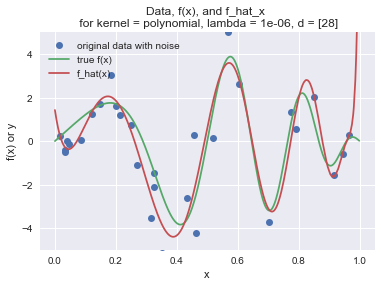

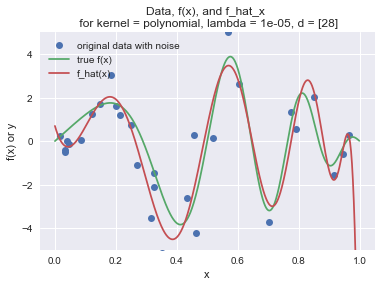

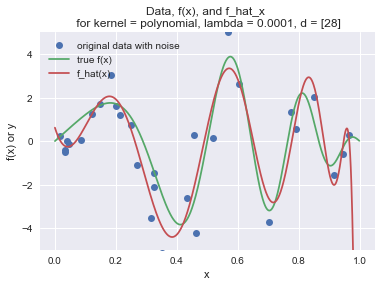

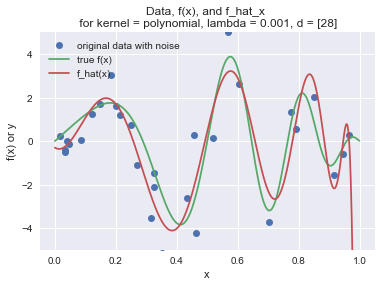

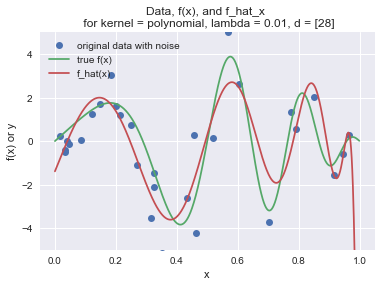

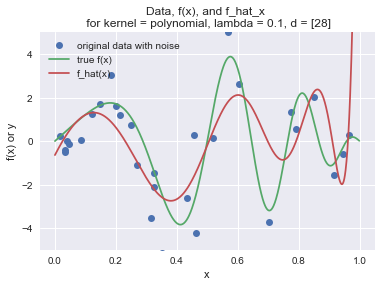

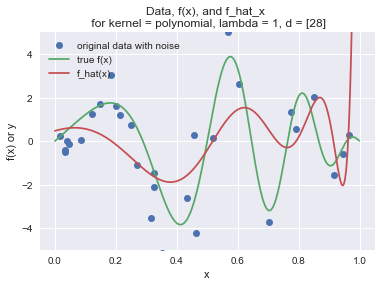

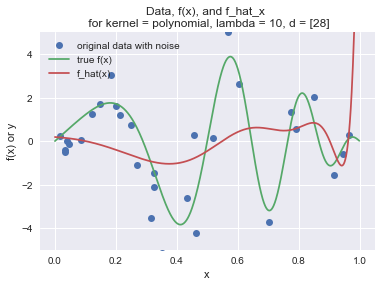

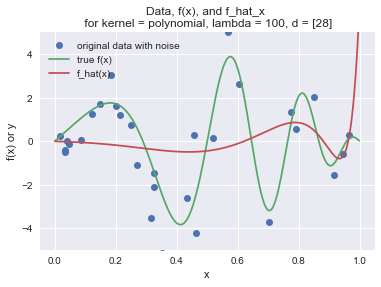

In [14]:
d_vec = np.arange(1,29,3)


for d in d_vec:
    
    K = make_K_mat_poly(x,d)
    
lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]

d = np.array([28])
#lambda_vec = np.array([0.001])

for lambda_val in lambda_vec:
    f_hat = np.zeros((x_cont.shape))
    
    K = make_K_mat_poly(x,d)
    alpha_hat = alpha_hat_compute(K,lambda_val,y)
    
    #f_hat = f_hat_compute(alpha_hat,K)
    
    for i in np.arange(x_cont.shape[0]):

        eval_kernel = kernel_eval_poly(d,float(x_cont[i]),x)
        predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))
        
        f_hat[i] = predict_y
        
    plot_function_poly(x,y,x_cont,f_x,f_hat,'polynomial',lambda_val,d)

### rbf kernel

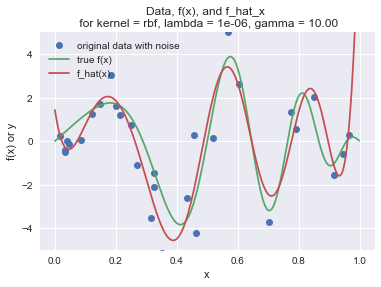

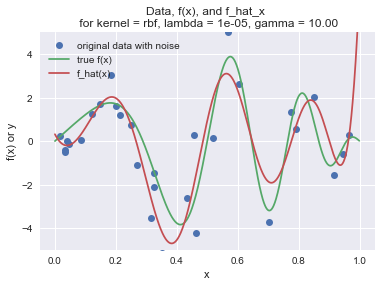

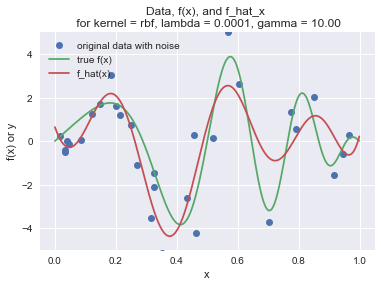

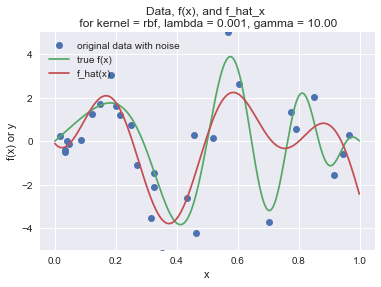

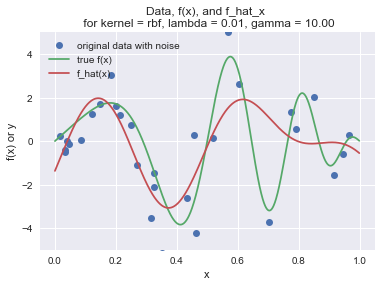

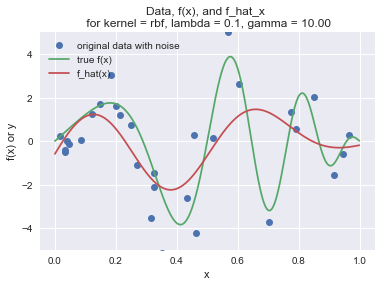

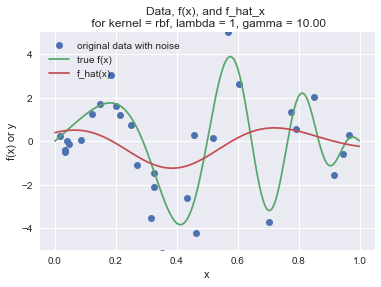

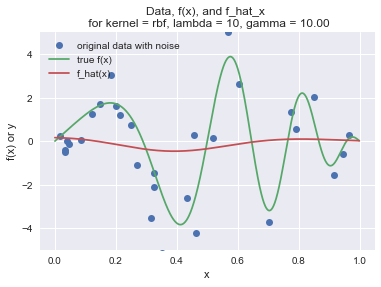

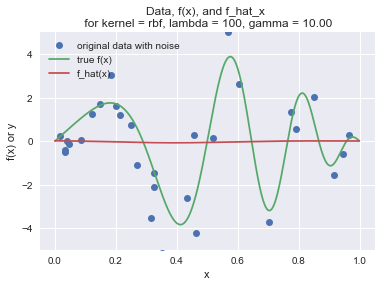

In [15]:
# choose gamma 
gamma = choose_gamma(x)

gamma = 10

K = make_K_mat_rbf(x,gamma)

lambda_vec = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100]

for lambda_val in lambda_vec:
    alpha_hat = alpha_hat_compute(K,lambda_val,y)

    f_hat = np.zeros((x_cont.shape))

    for i in np.arange(x_cont.shape[0]):
        eval_kernel = kernel_eval_rbf(gamma,float(x_cont[i]),x)
        predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))
        f_hat[i] = predict_y
    
    plot_function_rbf(x,y,x_cont,f_x,f_hat,'rbf',lambda_val,gamma)

### try cross validation - polynomial

lambda = 1e-05,d=1.0
lambda = 1e-05,d=4.0
lambda = 1e-05,d=7.0
lambda = 1e-05,d=10.0
lambda = 1e-05,d=13.0
lambda = 1e-05,d=16.0
lambda = 1e-05,d=19.0
lambda = 1e-05,d=22.0
lambda = 1e-05,d=25.0
lambda = 1e-05,d=28.0
lambda = 1e-05,d=31.0
lambda = 1e-05,d=34.0
lambda = 1e-05,d=37.0
lambda = 1e-05,d=40.0
lambda = 1e-05,d=43.0
lambda = 1e-05,d=46.0
lambda = 1e-05,d=49.0
lambda = 0.0001,d=1.0
lambda = 0.0001,d=4.0
lambda = 0.0001,d=7.0
lambda = 0.0001,d=10.0
lambda = 0.0001,d=13.0
lambda = 0.0001,d=16.0
lambda = 0.0001,d=19.0
lambda = 0.0001,d=22.0
lambda = 0.0001,d=25.0
lambda = 0.0001,d=28.0
lambda = 0.0001,d=31.0
lambda = 0.0001,d=34.0
lambda = 0.0001,d=37.0
lambda = 0.0001,d=40.0
lambda = 0.0001,d=43.0
lambda = 0.0001,d=46.0
lambda = 0.0001,d=49.0
lambda = 0.001,d=1.0
lambda = 0.001,d=4.0
lambda = 0.001,d=7.0
lambda = 0.001,d=10.0
lambda = 0.001,d=13.0
lambda = 0.001,d=16.0
lambda = 0.001,d=19.0
lambda = 0.001,d=22.0
lambda = 0.001,d=25.0
lambda = 0.001,d=28.0
lambda = 0.001,d=31.0
la

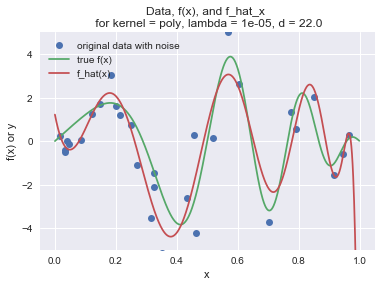

In [ ]:
lambda_vec = np.array([1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100])
d_vec = np.arange(1.0,50.0,3)

#d_vec = np.array([1,20])
score_vec = LOOCV_poly(x,y,lambda_vec,d_vec)
best_ind_p = np.unravel_index(score_vec.argmin(), score_vec.shape)

best_d = float(d_vec[best_ind_p[1]])
best_lambda = lambda_vec[best_ind_p[0]]

#best_lambda = 1e-6

f_hat = np.zeros((x_cont.shape))
  
K = make_K_mat_poly(x,best_d)
alpha_hat = alpha_hat_compute(K,best_lambda,y)

for i in np.arange(x_cont.shape[0]):
    eval_kernel = kernel_eval_poly(best_d,float(x_cont[i]),x)
    predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))

    f_hat[i] = predict_y
        
plot_function_poly(x,y,x_cont,f_x,f_hat,'poly',best_lambda,best_d)

### statistical test

In [7]:
x_stat,y_stat,f_x_stat,x_cont_stat = generate_data()

f_hat_stat_poly = np.zeros((x_stat.shape))
  
K = make_K_mat_poly(x,best_d)
alpha_hat = alpha_hat_compute(K,best_lambda,y)

for i in np.arange(x_stat.shape[0]):
    eval_kernel = kernel_eval_poly(best_d,float(x_cont[i]),x)
    predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))

    f_hat_stat_poly[i] = predict_y

error_poly = (f_hat_stat_poly - y_stat)**2

### bootstrap

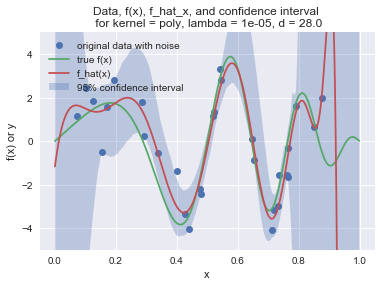

In [17]:
num_sets = 300
num_pulls = 30 
bootstrapped_examples_poly = bootstrap_poly(best_d,best_lambda,x,y,x_cont,num_sets,num_pulls)

lower_poly,upper_poly = np.percentile(bootstrapped_examples_poly,[2.5,97.5],axis=0)

kernel = 'poly'
plot_function_poly_boot(x,y,x_cont,f_x,f_hat,kernel,best_lambda,best_d,lower_poly,upper_poly)

### try cross validation - rbf

In [ ]:
lambda_vec = np.array([1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100])

gamma = choose_gamma(x)

gamma_vec = np.arange(gamma-10,gamma+20,5)

score_vec = LOOCV_rbf(x,y,lambda_vec,gamma_vec)

best_ind = np.unravel_index(score_vec.argmin(), score_vec.shape)

best_gamma = gamma_vec[best_ind[1]]
best_lambda = lambda_vec[best_ind[0]]

f_hat = np.zeros((x_cont.shape))

K = make_K_mat_rbf(x,best_gamma)
alpha_hat = alpha_hat_compute(K,best_lambda,y)
for i in np.arange(x_cont.shape[0]):
    eval_kernel = kernel_eval_rbf(best_gamma,float(x_cont[i]),x)
    predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))
    f_hat[i] = predict_y


    
plot_function_rbf(x,y,x_cont,f_x,f_hat,'rbf',best_lambda,best_gamma)

lambda = 1e-05,gamma = 1.8451700029375715
lambda = 1e-05,gamma = 6.8451700029375715
lambda = 1e-05,gamma = 11.845170002937571
lambda = 1e-05,gamma = 16.84517000293757
lambda = 1e-05,gamma = 21.84517000293757
lambda = 1e-05,gamma = 26.84517000293757


### statistical test

Ttest_indResult(statistic=array([-1.10035243]), pvalue=array([ 0.2757246]))

2.5861159806160869

4.7510616693636623

Text(0.5,0,'squared error')

Text(0,0.5,'fraction of occurence')

Text(0.5,1,'Comparing the distribution of errors for the rbf and poly kernels')

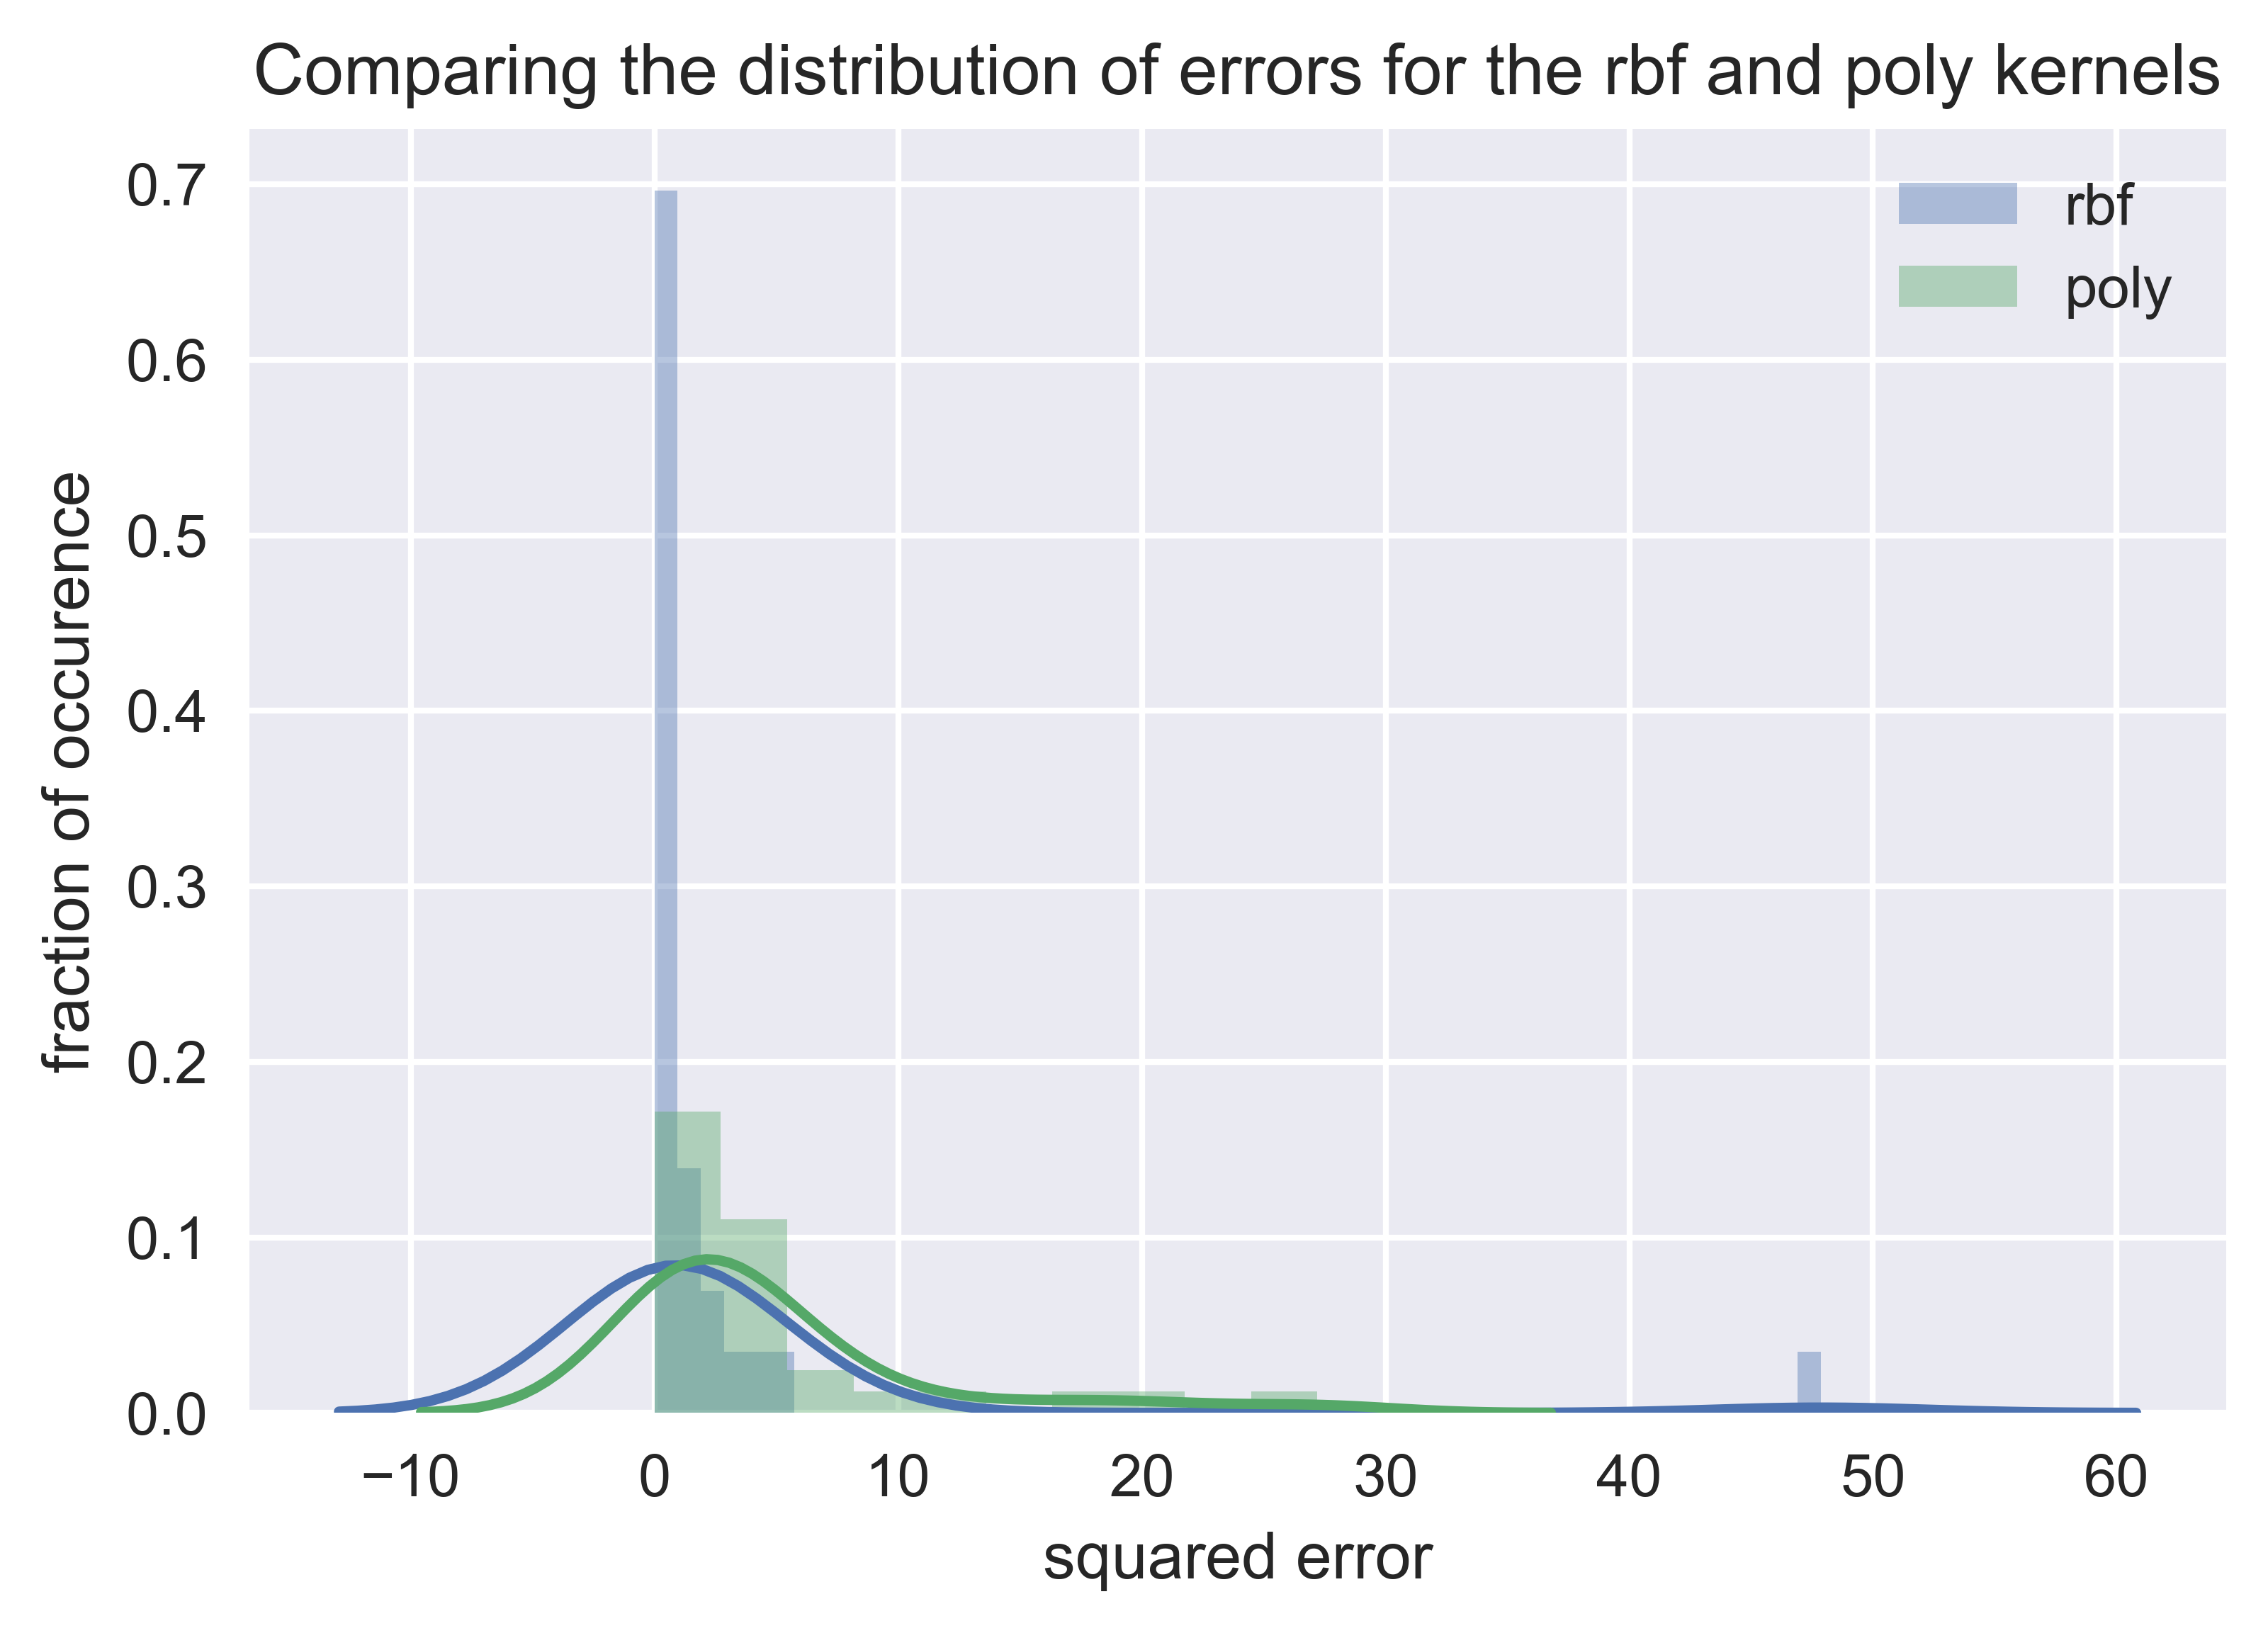

In [19]:
  
f_hat_stat_rbf = np.zeros((x_stat.shape))

K = make_K_mat_rbf(x,best_gamma)
alpha_hat = alpha_hat_compute(K,best_lambda,y)
for i in np.arange(x_stat.shape[0]):
    eval_kernel = kernel_eval_rbf(best_gamma,float(x_stat[i]),x)
    predict_y = np.sum(alpha_hat.flatten()*np.array(eval_kernel))
    f_hat_stat_rbf[i] = predict_y
    
error_rbf = (f_hat_stat_rbf - y_stat)**2

scipy.stats.ttest_ind(error_rbf,error_poly)

np.mean(error_rbf)
np.mean(error_poly)

plt.figure(dpi=600)
sns.distplot(error_rbf,label='rbf')
sns.distplot(error_poly,label='poly')
plt.xlabel('squared error')
plt.ylabel('fraction of occurence')
plt.legend()
plt.title('Comparing the distribution of errors for the rbf and poly kernels')
plt.savefig('hw3_kernel_statstest')

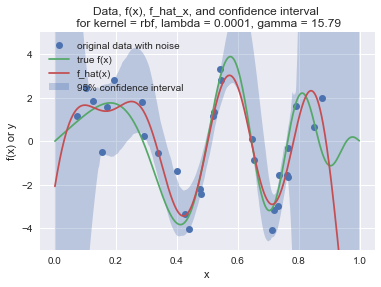

In [20]:
num_sets = 300
num_pulls = 30 
bootstrapped_examples_rbf = bootstrap_rbf(best_gamma,best_lambda,x,y,x_cont,num_sets,num_pulls)

lower_rbf,upper_rbf = np.percentile(bootstrapped_examples_poly,[2.5,97.5],axis=0)
kernel = 'rbf'
plot_function_rbf_boot(x,y,x_cont,f_x,f_hat,kernel,best_lambda,best_gamma,lower_poly,upper_poly)